<!-- # TODO

- attach_results bug (possibly resolved)
- add asserts where appropriate
- Add FIFO optimization
- switch to QAT
- add table of contents
- update MNIST tutorial
- put reference design on Zenodo
- add doc comments

- allow user to make 8, 12, or 16 bit
- allow user to select Octo or Quad CXP-12
- include envionrment yml -->

# Part 9: Frame Grabbers

## Table of Contents
- Helpful functions for dataset
- Helpful functions for training
- Make dataset
- Model training
    - Keras model classification performance
- Extensions API for custom layer
- Post-training quantization, compiling an hls4ml model
- HLS model profiling
- Simulate HLS model
    - HLS model classification performance
- FIFO Optimization
- Frame grabber firmware integration
    - Acquisition parameters
    - C-simulation
    - Frame grabber model classification performance
    - C-synthesis
    - Implementation
    - Benchmarking

This tutorial will cover the training and deployment of YOLO-type neural networks to high-speed frame grabbers, specifically the Euresys Octo and Quad CXP-12. It also covers the hls4ml extensions API, HLS model profiling, and FIFO optimization.

IMPORTANT: Be sure to activate ```hls4ml_frame_grabber``` conda environment (README for instructions on installing).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil
import os 

import hls4ml
from hls4ml.model.profiling import numerical

import tensorflow as tf
from tensorflow.keras import layers, activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, Activation, Flatten, AveragePooling2D, MaxPool2D, Concatenate, Input
from tensorflow.keras.models import Model

from qkeras.qlayers import QDense, QActivation
from qkeras.qconvolutional import QConv2D
from qkeras.qpooling import QAveragePooling2D
from qkeras.quantizers import quantized_bits, quantized_relu, smooth_sigmoid

2024-06-21 16:22:18.924669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rforelli/miniforge3/envs/folo_frame_grabber/lib/python3.8/site-packages/cv2/../../lib64:/home/rforelli/miniforge3/lib:
2024-06-21 16:22:18.924702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Helpful functions for dataset

This fake YOLO (FOLO) will have non-standard small pure CNN architecture suitable for deployment to more resource-constrained FPGA devices such these which come equipped with an XCKU035. The dataset will consist of 128x48 frames with MNIST digits randomly inserted throughout. This model and code is adapted from Seachaos' Medium article [here](https://tree.rocks/a-simple-way-to-understand-and-implement-object-detection-from-scratch-by-pure-cnn-36cc28143ca8).

In [2]:
grid_size = 16  # image_size / mask_size
threshold = 0.65
data_size = 100

def make_numbers(X, y): 
    """
    Generates a new data sample by placing random MNIST digits around a 128x48 frame
    
    :param X: New empty FOLO data array
    :param y: New empty FOLO labels data array
    """
    
    for _ in range(3): # place three digits around the image
        
        idx = np.random.randint(len(X_num)) # pick a random digit to insert in frame 
        number = X_num[idx] # grab digit
        kls = y_num[idx]    # grab class
        
        px, py = np.random.randint(0, 100), np.random.randint(0, 20) # generate a random position for the digit
        
        mx, my = (px+14) // grid_size, (py+14) // grid_size # calculate which mask region the digit will belong to
        channels = y[my][mx]

        # prevent duplicates
        if channels[0] > 0:
            continue
            
        channels[0] = 1.0
        channels[1] = px - (mx * grid_size)  # x1
        channels[2] = py - (my * grid_size)  # y1
        channels[3] = 28.0                   # x2
        channels[4] = 28.0                   # y2
        channels[5 + kls] = 1.0
        
        # Insert digit to frame
        X[py:py+28, px:px+28] += number
        
def make_data(size=64):
    """
    Generates a new dataset for FOLO training
    
    :param size: Number of samples to generate for training, can be larger than MNIST dataset
    :return: New dataset and labels
    """

    X = np.zeros((size, 48, 128, 1), dtype=np.float32)  # New data sample of 128x48 images
    y = np.zeros((size, 3, 8, 15), dtype=np.float32)    # New data output consists of probability, bounding box, and class
    
    # Generate data
    for i in range(size): 
        make_numbers(X[i], y[i])
        
    X = np.clip(X, 0.0, 1.0)
    return X, y

def show_predict(X, y, threshold=0.1):
    """
    Display single prediction results
    
    :param X: Data sample input
    :param y: Model predictions
    :param threshold: Probability threshold    
    """
    
    X = X.copy()
    for mx in range(8):
        for my in range(3):
            channels = y[my][mx]
            prob, x1, y1, x2, y2 = channels[:5]

            # if prob < threshold we won't show any thing
            if prob < threshold:
                continue
                                
            color = 255
            # bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1
            cv2.rectangle(X, (int(px), int(py)), (int(px + x2), int(py + y2)), -1, 1)
            
            # label
            cv2.rectangle(X, (int(px), int(py - 10)), (int(px + 12), int(py)), -1, -1)
            kls = np.argmax(channels[5:])
            cv2.putText(X, f'{kls}', (int(px + 2), int(py-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

            print("digit: " + str(np.argmax(channels[5:15])) + ", prob: " + str(prob) + ", x1: " + str(int(px)) + ", y1: " + str(int(py)) + ", x2: " + str(int(px + x2)) + ", y2: " + str(int(py + y2)))
            
    plt.imshow(X, cmap="gray")

def eval_model_cls_performance(y_pred, y):

    y_pred_flattened = y_pred.reshape(-1, 15)
    filtered_indices = y_pred_flattened[:, 0] > threshold
    filtered_y_pred = y_pred_flattened[filtered_indices]
    filtered_y = y.reshape(-1, 15)[filtered_indices]

    predicted_labels_y_pred = np.argmax(filtered_y_pred[:, 5:15], axis=1)
    predicted_labels_y = np.argmax(filtered_y[:, 5:15], axis=1)

    return predicted_labels_y_pred, predicted_labels_y    


## Helpful functions for training

In [3]:
idx_p = [0] # probability
idx_bb = [1, 2, 3, 4] # bounding box
idx_cls = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # class

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

## Make dataset

In [4]:
(X_num, y_num), _ = tf.keras.datasets.mnist.load_data()
X_num = np.expand_dims(X_num, axis=-1).astype(np.float32) / 255.0

Let's load  take a look at a sample of our data as well as the corrsponding labels

digit: 6, prob: 1.0, x1: 20, y1: 3, x2: 48, y2: 31
digit: 1, prob: 1.0, x1: 44, y1: 4, x2: 72, y2: 32
digit: 4, prob: 1.0, x1: 72, y1: 0, x2: 100, y2: 28


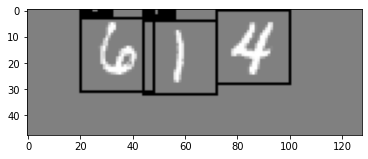

In [5]:
X, y = make_data(size=data_size)
show_predict(X[0], y[0])

## Model training

In [6]:
def FOLO_conv():
    """
    FOLO model architecture using standard Keras layers.

    :return: Keras model
    """
    
    inputs = Input(shape=(48, 128, 1), name='input_1')

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Output layers
    x_prob = Conv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid')(x)
    x_boxes = Conv2D(4, kernel_size=3, padding='same', name='x_boxes', activation='linear')(x)
    x_cls = Conv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid')(x)

    # Applying gate
    gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
    x_boxes = x_boxes * gate
    x_cls = x_cls * gate

    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])

    model = Model(inputs, x)
    return model

In [7]:
model = FOLO_conv()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 128, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 64, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 64, 16)  64          ['max_pooling2d[0][0]']      

2024-06-21 16:22:22.349818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rforelli/miniforge3/envs/folo_frame_grabber/lib/python3.8/site-packages/cv2/../../lib64:/home/rforelli/miniforge3/lib:
2024-06-21 16:22:22.349847: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-21 16:22:22.349876: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator2.fnal.gov): /proc/driver/nvidia/version does not exist
2024-06-21 16:22:22.350098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

In [8]:
model.compile(loss=loss_func, optimizer=opt)

In [9]:
# Uncomment below to enable training
# batch_size = 32
# X_train, y_train = make_data(size=batch_size * 400)
# model.fit(X_train, y_train, batch_size=batch_size, epochs=30, shuffle=True)

In [10]:
# model.save_weights('weights/folo_weights.h5')
model.load_weights('weights/folo_weights.h5') # Load if you would like to skip training

### Keras model classification performance

Lets get an idea of how the model is performing. We expect this model to perform worse than standard MNIST classifiers as digits are allowed to overlap and are more likely to do so at smaller resolutions in cases such as this.

digit: 6, prob: 0.9981272, x1: 21, y1: 4, x2: 48, y2: 30
digit: 1, prob: 0.99995625, x1: 45, y1: 3, x2: 72, y2: 31
digit: 4, prob: 1.0, x1: 70, y1: 1, x2: 102, y2: 33


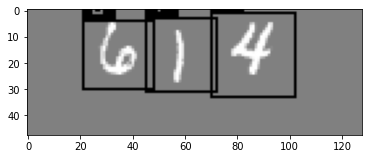

In [11]:
keras_y_pred = model.predict(X)
show_predict(X[0], keras_y_pred[0], threshold=threshold)

In [12]:
keras_y_pred_ex, y_ex = eval_model_cls_performance(keras_y_pred, y)
FOLO_accuracy_keras = np.mean(keras_y_pred_ex == y_ex) * 100
print(f'FOLO classification accuracy: {FOLO_accuracy_keras:.2f}%')

FOLO classification accuracy: 76.30%


## Extensions API for custom layer

The extensions API enables hls4ml users to implement custom layers in their model given the HLS implementation of the layer which is inserted to the HLS model. In this example, the custom layer we are inserting is not utilized during training but is actually for data reduction in hardware. The current model output is of shape (8,3,15) which can be reduced to twenty-four 31-bit values denoting a probability gated to a 1 or 0, four 7 and 6-bit bounding box coordinates, and a 4-bit class. The implementation for this layer is included in ``nnet_reduce.h``

In [13]:
class KReduce(tf.keras.layers.Layer):
    '''Keras implementation of custom layer'''
    
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        # inputs: a tensor of shape(8,3,15)            
        return inputs[:, :, :, 0] # We want our hardware model output to be of shape (1,8,3,1)

class HReduce(hls4ml.model.layers.Layer):
    '''hls4ml implementation of custom layer'''

    def initialize(self):
        inp = self.get_input_variable()
        shape = list(inp.shape)
        shape[-1] = 1 # new output shape is (1,8,3,1)
        
        dims = ['OUT_HEIGHT_{}'.format(self.index), 'OUT_WIDTH_{}'.format(self.index), 'N_FILT_{}'.format(self.index)]
        
        self.add_output_variable(shape, dims)

def parse_reduce_layer(keras_layer, input_names, input_shapes, data_reader):
    '''Parser for converter'''
    
    layer = {}
    layer['class_name'] = 'HReduce'
    layer['name'] = keras_layer['config']['name']
    layer['n_in'] = input_shapes[0][1]*input_shapes[0][2]
    layer['grid_size'] = grid_size
    outshape = [[None, 3, 8]]

    if input_names is not None:
        layer['inputs'] = input_names

    return layer, outshape

# HLS model layer configuration
red_config_template = """struct config{index} : nnet::reduce_config {{
    static const unsigned n_in = {n_in};
    static const unsigned grid_size = {grid_size};
}};\n"""

red_function_template ='nnet::reduce<{input_t}, {output_t}, {config}>({input}, {output});'
red_include_list = ['nnet_utils/nnet_reduce.h']

class HReduceConfigTemplate(hls4ml.backends.template.LayerConfigTemplate):
    def __init__(self):
        super().__init__(HReduce)
        self.template = red_config_template

    def format(self, node):
        params = self._default_config_params(node)
        return self.template.format(**params)

class HReduceFunctionTemplate(hls4ml.backends.template.FunctionCallTemplate):
    '''New layer function template'''
    
    def __init__(self):
        super().__init__(HReduce, include_header=red_include_list)
        self.template = red_function_template

    def format(self, node):
        params = self._default_function_params(node)
        return self.template.format(**params)

# Register the converter for custom Keras layer
hls4ml.converters.register_keras_layer_handler('KReduce', parse_reduce_layer)

# Register the hls4ml's IR layer
hls4ml.model.layers.register_layer('HReduce', HReduce)

for backend_id in ['Vivado']:
    # Register the optimization passes (if any)
    backend = hls4ml.backends.get_backend(backend_id)

    # Register template passes for the given backend
    backend.register_template(HReduceConfigTemplate)
    backend.register_template(HReduceFunctionTemplate)

    # Register HLS implementation
    backend.register_source(os.path.abspath("lambda_cpp/nnet_reduce.h"))

Now define the model with the new layer and copy the weights over. This new model will not provide correct results in Python but will in hardware with the addition of the final ``reduce()`` layer

In [14]:
class quantized_relu(quantized_relu):
    ''' Workaround for quantized_relu __name__ not found bug '''
    def __init__(self, W, I):
        super(quantized_relu, self).__init__(W, I)
        self.__name__ = 'quantized_relu'

def FOLO_conv_reduce():
    """
    Baby FOLO model architecture with new custom layer
    
    :return: Keras model
    """
    
    tf.compat.v1.reset_default_graph()
    x = inputs = Input(shape=(48, 128, 1), name='input_1')

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(inputs)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Output layers
    x_prob = Conv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid')(x)
    x_boxes = Conv2D(4, kernel_size=3, padding='same', name='x_boxes', activation='linear')(x)
    x_cls = Conv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid')(x)
    
    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])

    x = KReduce()(x)

    model = tf.keras.models.Model(inputs, x)
    return model        
    
model_reduce = FOLO_conv_reduce()
model_reduce.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 128, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 64, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 64, 16)  64          ['max_pooling2d[0][0]']      

In [15]:
model_reduce.load_weights('weights/folo_weights.h5')

In [16]:
 tf.keras.utils.plot_model(model_reduce)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Post-training quantization, compiling an hls4ml model

Here we will compile the HLS representation of our model with the custom layer. Notice we set the output precision to 31 bits as previously described. Weight and result precisions were determined by observing the model profiling plots found in the next section.

In [17]:
def print_dict(d, indent=0):
    """
    Prints dictionary to view hls4ml model config
    
    :return: Keras model
    """

    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value)) 

In [18]:
config = hls4ml.utils.config_from_keras_model (model_reduce,
                                                   default_precision = 'ap_fixed<32,16>',
                                                   granularity = 'name')

strategy = "Resource"
tracing = True
rf = 1
OUT_DIR = f'folo_on_frame_grabber'

config["Model"]["Strategy"] = strategy
config["Model"]["ReuseFactor"] = rf
for layer in config["LayerName"]:
    config["LayerName"][layer]["Trace"] = tracing
    
config["LayerName"]["conv2d"]['ReuseFactor'] = 3
config["LayerName"]["conv2d"]["Strategy"] = "Resource"
config["LayerName"]["conv2d"]["Precision"]["weight"] = "ap_fixed<16,4>"
config["LayerName"]["conv2d"]["Precision"]["bias"] = "ap_fixed<8,3>"
config["LayerName"]["conv2d"]["Precision"]["result"] = "ap_fixed<16,4>"

config["LayerName"]["conv2d_relu"]["Precision"]["result"] = "ap_ufixed<16,3>"

config["LayerName"]["max_pooling2d"]["Precision"]["result"] = "ap_ufixed<16,3>"

config["LayerName"]["batch_normalization"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["conv2d_1"]['ReuseFactor'] = 36
config["LayerName"]["conv2d_1"]["Strategy"] = "Resource"
config["LayerName"]["conv2d_1"]["Precision"]["weight"] = "ap_fixed<18,5>"
config["LayerName"]["conv2d_1"]["Precision"]["bias"] = "ap_fixed<15,4>"
config["LayerName"]["conv2d_1"]["Precision"]["result"] = "ap_fixed<16,10>"

config["LayerName"]["conv2d_1_relu"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["max_pooling2d_1"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["batch_normalization_1"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["conv2d_2"]['ReuseFactor'] = 144
config["LayerName"]["conv2d_2"]["Strategy"] = "Resource"
config["LayerName"]["conv2d_2"]["Precision"]["weight"] = "ap_fixed<16,3>"
config["LayerName"]["conv2d_2"]["Precision"]["bias"] = "ap_fixed<9,2>"
config["LayerName"]["conv2d_2"]["Precision"]["result"] = "ap_fixed<16,10>"

config["LayerName"]["conv2d_2_relu"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["max_pooling2d_2"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["batch_normalization_2"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["conv2d_3"]['ReuseFactor'] = 576
config["LayerName"]["conv2d_3"]["Strategy"] = "Resource"
config["LayerName"]["conv2d_3"]["Precision"]["weight"] = "ap_fixed<18,5>"
config["LayerName"]["conv2d_3"]["Precision"]["bias"] = "ap_fixed<12,5>"
config["LayerName"]["conv2d_3"]["Precision"]["result"] = "ap_fixed<16,10>"

config["LayerName"]["conv2d_3_relu"]["Precision"]["result"] = "ap_ufixed<16,8>"

config["LayerName"]["max_pooling2d_3"]["Precision"]["result"] = "ap_ufixed<16,8>"

config["LayerName"]["batch_normalization_3"]["Precision"]["result"] = "ap_fixed<16,4>"

config["LayerName"]["x_prob"]['ReuseFactor'] = 144
config["LayerName"]["x_prob"]["Strategy"] = "Resource"
config["LayerName"]["x_prob"]["Precision"]["weight"] = "ap_fixed<13,3>"
config["LayerName"]["x_prob"]["Precision"]["bias"] = "ap_fixed<5,3>"
config["LayerName"]["x_prob"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["x_prob_sigmoid"]["Precision"]["result"] = "ap_ufixed<16,0>"

config["LayerName"]["x_boxes"]['ReuseFactor'] = 576
config["LayerName"]["x_boxes"]["Strategy"] = "Resource"
config["LayerName"]["x_boxes"]["Precision"]["weight"] = "ap_fixed<19,5>"
config["LayerName"]["x_boxes"]["Precision"]["bias"] = "ap_fixed<7,5>"
config["LayerName"]["x_boxes"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["x_boxes_linear"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["concatenate"]["Precision"]["result"] = "ap_fixed<16,7>"


config["LayerName"]["x_cls"]['ReuseFactor'] = 1440 
config["LayerName"]["x_cls"]["Strategy"] = "Resource"
config["LayerName"]["x_cls"]["Precision"]["weight"] = "ap_fixed<21,5>"
config["LayerName"]["x_cls"]["Precision"]["bias"] = "ap_fixed<7,3>"
config["LayerName"]["x_cls"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["x_cls_sigmoid"]["Precision"]["result"] = "ap_ufixed<16,0>"

config["LayerName"]["concatenate_1"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["k_reduce"]["Precision"]["result"] = "ap_uint<31>"

print_dict(config)
    
hls_model = hls4ml.converters.convert_from_keras_model(model_reduce,
                                                       hls_config = config,
                                                       io_type = 'io_stream',
                                                       output_dir = OUT_DIR,
                                                       part='xcku035-fbva676-2-e'
                                                       )

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer na

Done


## HLS model profiling

Now we will take a look two very useful types of plots. The first is to compare the precision ranges of our model weights to the precision able to represented by the HLS model's fixed-point precision types. The second compares the model outputs of our HLS model to the Keras model. We will disregard the ``reduce`` layer output since our keras model does not implement that layer. These plots give us a sense of what precisions we should set for each layer to optimize across accuracy and resources. We can tell how closely we've matched the float model but looking at the output layer plot (or in this case second to last), ```concatenate_1```.

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer na

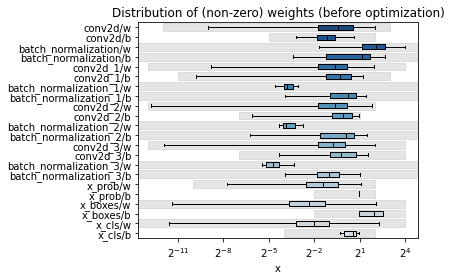

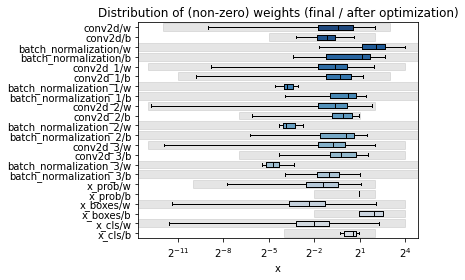

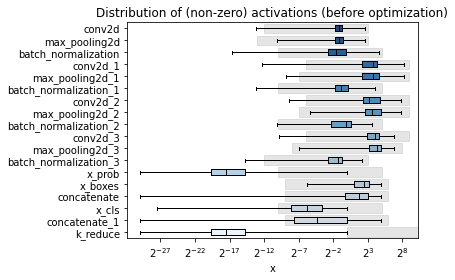

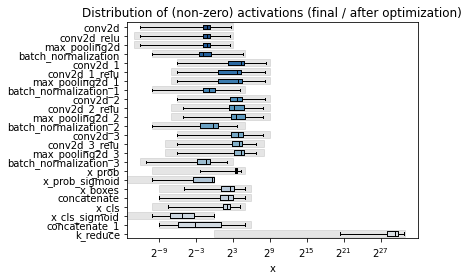

In [19]:
#Compare weights ranges between float and HLS model
X_profile, y_profile = make_data(size=10)
%matplotlib inline
plots = hls4ml.model.profiling.numerical(model=model_reduce, hls_model = hls_model, X=np.ascontiguousarray(X_profile))

Done taking outputs for Keras model.
Recompiling myproject with tracing
Writing HLS project
Done


/tmp/ipykernel_26884/3770013867.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


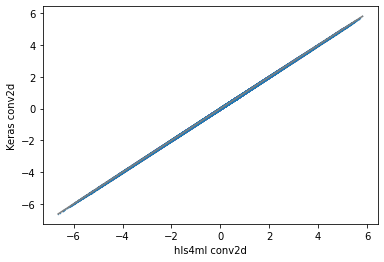

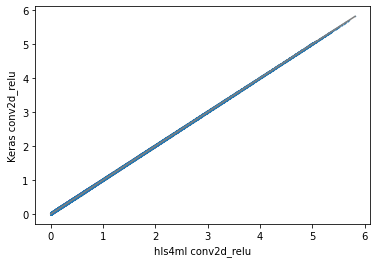

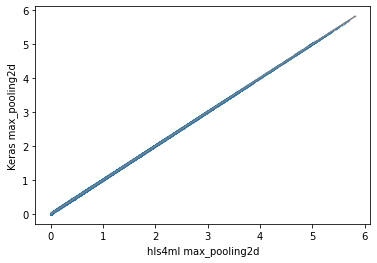

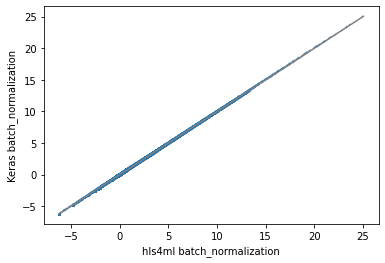

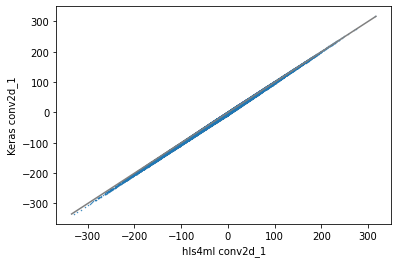

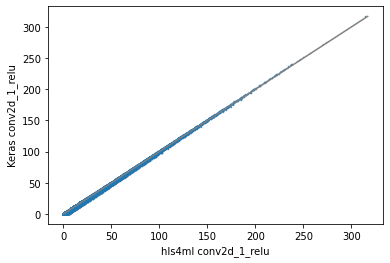

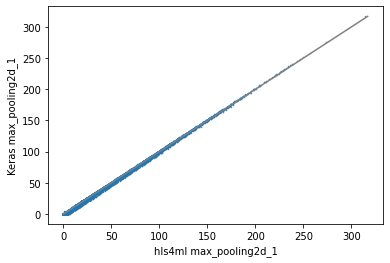

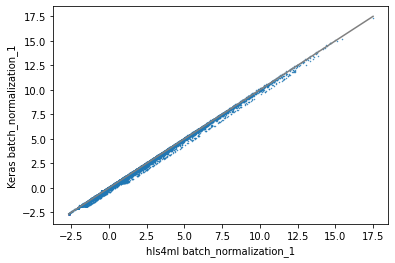

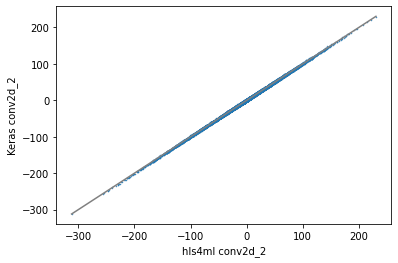

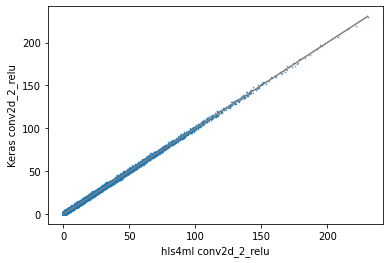

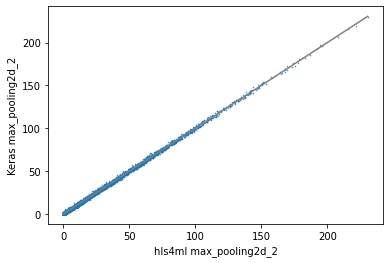

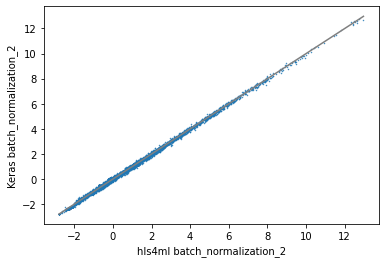

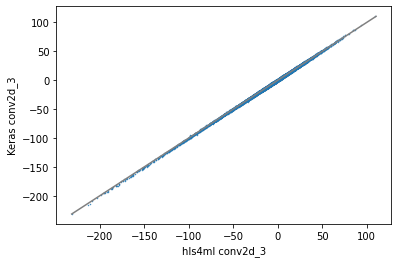

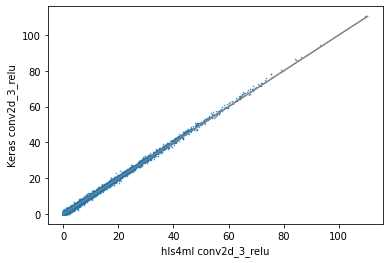

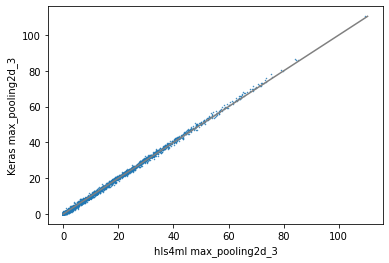

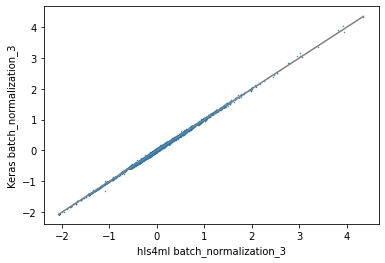

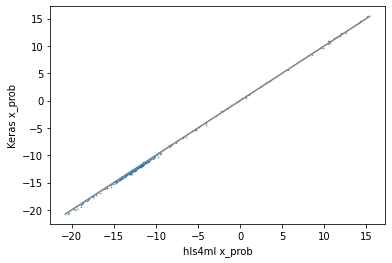

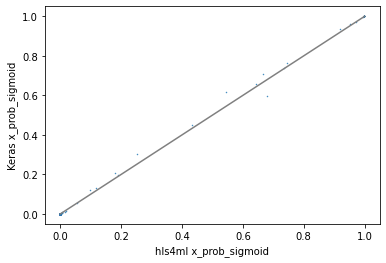

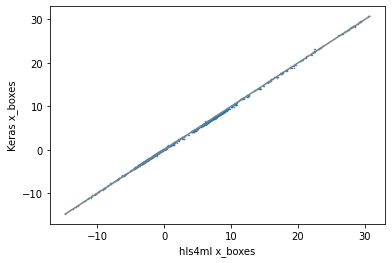

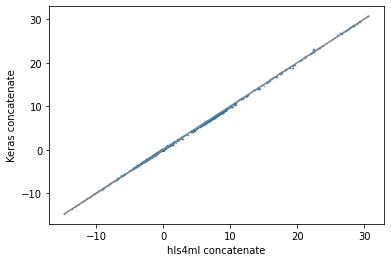

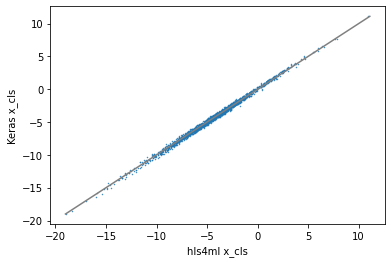

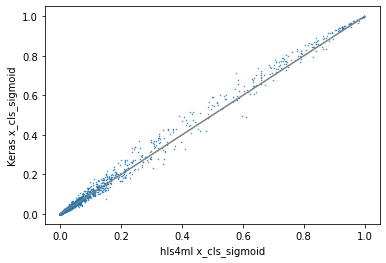

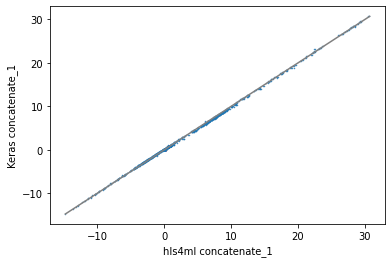

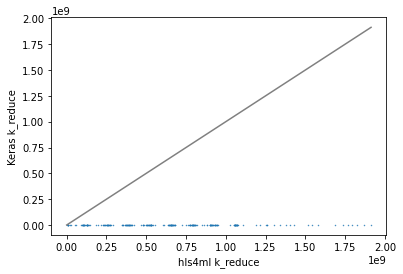

In [20]:
#Trace Model
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model_reduce, np.ascontiguousarray(X_profile))
y_hls, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X_profile))

#Compare layer outputs
for layer in hls4ml_trace.keys():
            plt.figure()
            klayer = layer
            if "_alpha" in layer:
                klayer = layer.replace("_alpha", "")
            if "_linear" in layer:
                klayer = layer.replace("_linear", "")
            plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
            min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
            max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
            plt.plot([min_x, max_x], [min_x, max_x], c="gray")
            plt.xlabel("hls4ml {}".format(layer))
            plt.ylabel("Keras {}".format(klayer))

## Simulate HLS model

Before we integrate our neural network into the frame grabber reference design. Lets make sure it's providing solid results by running csim. We will need to save our test data to the testbennch folder

In [21]:
np.savetxt(OUT_DIR + "/tb_data/tb_input_features.dat", X.reshape(X.shape[0], -1), delimiter=' ')
np.savetxt(OUT_DIR + "/tb_data/tb_output_predictions.dat", np.zeros(y.shape[0:3]).reshape(y.shape[0], -1), delimiter=' ') # no need to save true y's since we have to parse bitstring outputs

In [22]:
hls_model.build(csim=True, synth=False, cosim=False, validation=False, vsynth=False, fifo_opt=False, export=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /data1/rforelli/Xilinx_2018/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/data1/rforelli/Xilinx_2018/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rforelli' on host 'correlator2.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Fri Jun 21 16:23:03 CDT 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber'
INFO: [HLS 200-10] Creating and opening project '/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10

{'CSimResults': [['1073483833',
   '142640376',
   '167812406',
   '403236049',
   '528567641',
   '1661180436',
   '771854471',
   '939513945',
   '1067061545',
   '143816022',
   '1250475494',
   '1443308017',
   '487532921',
   '621629716',
   '781819241',
   '907794793',
   '1052642921',
   '95962665',
   '272137654',
   '406502852',
   '523312649',
   '640894432',
   '775654985',
   '910021209'],
  ['8132681',
   '108942457',
   '234915929',
   '386452633',
   '537341159',
   '595684675',
   '814331126',
   '922866793',
   '1066934633',
   '93870457',
   '253535620',
   '371394152',
   '463551092',
   '1652783523',
   '1829494304',
   '890884457',
   '1060901449',
   '104355417',
   '246845993',
   '405082726',
   '1512391396',
   '649670054',
   '792295862',
   '935059033'],
  ['1056971929',
   '92431607',
   '259953753',
   '394189945',
   '520034409',
   '646269033',
   '780894359',
   '956161079',
   '1589705',
   '1091469911',
   '245010745',
   '370728313',
   '513347913',
 

In [23]:
hls_predictions = np.genfromtxt(OUT_DIR + "/tb_data/csim_results.log", delimiter=' ')

In [24]:
def bit_range(num, end_idx, start_idx):
    """
    Extracts bit range from integer
    
    :param num: Number from which to extract bits
    :param end_idx: Ending index (inclusive) from the right in the binary representation
    :param start_idx: Starting index (inclusive) from the right in the binary representation
    :return: Extracted bit range as an integer
    """
    
    mask = ((1 << (end_idx + 1)) - 1) - ((1 << start_idx) - 1)
    return (num & mask) >> start_idx

def one_hot_encode(digit):
    """
    One-hot encode a digit into a 10-element vector.
    
    :param digit: Digit to encode
    :return: encoding
    """
    
    encoding = np.zeros(10, dtype=int)
    encoding[digit] = 1
    return encoding

def show_predict_hardware(X, y):
    """
    Display single prediction results from the hardware (parsed from the output bit strings)
    
    :param X: Data sample input
    :param y: Model predictions
    """
    
    X = X.copy()
    channels = np.zeros((6), dtype=np.uint64)
    
    for i in range(24):
        channels[0] = bit_range(int(y[i]), 30, 30)
        channels[1] = bit_range(int(y[i]), 29, 23)
        channels[2] = bit_range(int(y[i]), 22, 17)
        channels[3] = bit_range(int(y[i]), 16, 10)
        channels[4] = bit_range(int(y[i]), 9, 4)
        channels[5] = bit_range(int(y[i]), 3, 0)
        
        if channels[0] < 1:
            continue

        color = 255
        # bounding box
        cv2.rectangle(X, (channels[1], channels[2]), (channels[3], channels[4]), -1, 1)

        print("digit: " + str(channels[5]) + ", prob: " + str(channels[0]) + ", x1: " + str(int(channels[1])) + ", y1: " + str(int(channels[2])) + ", x2: " + str(int(channels[3])) + ", y2: " + str(int(channels[4])))

        # label
        cv2.rectangle(X, (int(channels[1]), int(channels[2]-10)), (int(channels[1]+12), int(channels[2])), -1, -1)
        kls = channels[5]
        cv2.putText(X, f'{kls}', (int(channels[1]+2), int(channels[2]-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

    plt.imshow(X, cmap="gray")

    
def eval_model_cls_performance(y_pred, y):
    """
    Evaluate models class performance
    
    :param y_pred: model predictions 
    :param y: true y
    :return predicted_labels_y_pred: y predicted
    :return predicted_labels_y: y label
    """
    
    y_pred_flattened = y_pred.reshape(-1, 15)
    filtered_indices = y_pred_flattened[:, 0] > threshold
    filtered_y_pred = y_pred_flattened[filtered_indices]
    filtered_y = y.reshape(-1, 15)[filtered_indices]

    predicted_labels_y_pred = np.argmax(filtered_y_pred[:, 5:15], axis=1)
    predicted_labels_y = np.argmax(filtered_y[:, 5:15], axis=1)

    return predicted_labels_y_pred, predicted_labels_y    
    
def create_FOLO_output_from_hardware(input_array):
    """
    Decode FOLO output from hardware
    
    :param input_array: FOLO hardware output 
    :return output_array: decoded FOLO output
    """
    
    output_array = np.zeros((input_array.shape[0]*input_array.shape[1], 15), dtype=int)
    
    idx = 0
    for i in range(input_array.shape[0]):
        for j in range(input_array.shape[1]):
            # First feature: just the first bit
            output_array[idx, 0] = bit_range(int(input_array[i, j]), 30, 30)

            # Subsequent bit ranges
            output_array[idx, 1] = bit_range(int(input_array[i, j]), 29, 23)
            output_array[idx, 2] = bit_range(int(input_array[i, j]), 22, 17)
            output_array[idx, 3] = bit_range(int(input_array[i, j]), 16, 10)
            output_array[idx, 4] = bit_range(int(input_array[i, j]), 9, 4)

            # One hot encoding for MNIST digits
            digit = bit_range(int(input_array[i, j]), 3, 0)
            output_array[idx, 5:15] = one_hot_encode(digit)

            idx += 1
    
    return output_array

digit: 4, prob: 1, x1: 70, y1: 1, x2: 102, y2: 33
digit: 6, prob: 1, x1: 21, y1: 4, x2: 47, y2: 30
digit: 1, prob: 1, x1: 44, y1: 3, x2: 72, y2: 31


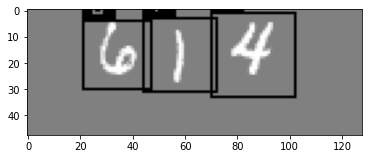

In [25]:
show_predict_hardware(X[0], hls_predictions[0])

### HLS model classification performance

In [26]:
hls_y_pred = create_FOLO_output_from_hardware(hls_predictions)

In [27]:
hls_y_pred_ex, y_ex = eval_model_cls_performance(hls_y_pred, y)
FOLO_accuracy_hls = np.mean(hls_y_pred_ex == y_ex) * 100
print(f'FOLO hls classification accuracy: {FOLO_accuracy_hls:.2f}%')

FOLO hls classification accuracy: 77.95%


## FIFO Optimization

Now we will run a fifo optimization. This process will optimize the depths of the FIFOs used to connect one layer to the next and will save tremendously on BRAM resources. Note that this process requires that we recompile our HLS model which will run c-simulation, c synthesis, and RTL simulation. This process is automated but can take some time. The HLS will automatically be updated with the new FIFO depths.

In [28]:
config['Flows'] = ['vivado:fifo_depth_optimization']
hls4ml.model.optimizer.get_optimizer('vivado:fifo_depth_optimization').configure(profiling_fifo_depth=6_500)

We don't want the FIFO optimization to take to long so let's save only three samples to the testbench

In [29]:
np.savetxt(OUT_DIR + "/tb_data/tb_input_features.dat", X.reshape(X.shape[0], -1)[0:3], delimiter=' ')
np.savetxt(OUT_DIR + "/tb_data/tb_output_predictions.dat", np.zeros(y.shape[0:3]).reshape(y.shape[0], -1)[0:3], delimiter=' ') # no need to save true y's since we have to parse bitstring outputs

In [30]:
hls_model = hls4ml.converters.convert_from_keras_model(model_reduce,
                                                       hls_config = config,
                                                       io_type = 'io_stream',
                                                       output_dir = OUT_DIR,
                                                       part='xcku035-fbva676-2-e'
                                                       )

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer na

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_resource.h:77) in function 'void nnet::dense_resource_rf_leq_nin<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>(FORWARD_REFERENCE*, FORWARD_REFERENCE*, FORWARD_REFERENCE::weight_t*, FORWARD_REFERENCE::bias_t*)' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'void nnet::shift_line_buffer<nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config16>(FORWARD_REFERENCE const&, ap_shift_reg<FORWARD_REFERENCE::value_type, FORWARD_REFERENCE::in_width> (*) [FORWARD_REFERENCE::n_chan], FORWARD_REFERENCE::value_type*)' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'void nnet::shift_line_buffer<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>

INFO: [XFORM 203-603] Inlining function 'nnet::Op_max<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (firmware/nnet_utils/nnet_common.h:45->firmware/nnet_utils/nnet_pooling_stream.h:21->firmware/nnet_utils/nnet_pooling_stream.h:204->firmware/nnet_utils/nnet_pooling_stream.h:247->firmware/nnet_utils/nnet_pooling_stream.h:257).
INFO: [XFORM 203-603] Inlining function 'nnet::Op_max<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (firmware/nnet_utils/nnet_common.h:43->firmware/nnet_utils/nnet_common.h:45->firmware/nnet_utils/nnet_pooling_stream.h:21->firmware/nnet_utils/nnet_pooling_stream.h:204->firmware/nnet_utils/nnet_poolin

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, sigmoid_config19>' (firmware/nnet_utils/nnet_activation_stream.h:90).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config18>' (firmware/nnet_utils/nnet_conv_stream.h:305).
INFO: [XFORM 203-603] Inlining function 'nnet::conv_2d_buffer_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config18>' into 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<1

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:53 ; elapsed = 00:00:54 . Memory (MB): peak = 620.000 ; gain = 196.129 ; free physical = 52920 ; free virtual = 144178
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:58 ; elapsed = 00:01:00 . Memory (MB): peak = 620.000 ; gain = 196.129 ; free physical = 52911 ; free virtual = 144174
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:84) into a 16-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:84) into a 160-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:45) into a 256-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:45) into a 256-bit variable.
INFO: [XFORM 203-1101] Packing var

INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ConcatLoopWidth' (firmware/nnet_utils/nnet_merge_stream.h:234) in function 'nnet::concatenate3d_2<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 15u>, config25>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'CloneLoop' (firmware/nnet_utils/nnet_stream.h:46) in function 'nnet::clone_stream<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, 384>' for pipelining.
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' (firmware/nnet_utils/nnet_conv_stream.h:194:62).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::arr

INFO: [HLS 200-489] Unrolling loop 'Loop-2.3' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config29>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-3.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config29>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-1.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config34>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in func

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (firmware/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'FiltLoop' (firmware/nnet_utils/nnet_pooling_stream.h:193) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'PoolLoop' (firmware/nnet_utils/nnet_pooling_stre

INFO: [HLS 200-489] Unrolling loop 'BatchNormpack' (firmware/nnet_utils/nnet_batchnorm_stream.h:33) in function 'nnet::normalize<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'BatchNormpack' (firmware/nnet_utils/nnet_batchnorm_stream.h:33) in function 'nnet::normalize<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config13>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'BatchNormpack' (firmware/nnet_utils/nnet_batchnorm_stream.h:33) in function 'nnet::normalize<nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config17>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'BatchNormpack' (firmware/nnet_utils/nnet_batchnorm

INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:197) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' completely with a factor of 3.
INFO: [HLS 200-489] Unr

INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling l

INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.13' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.18' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.23' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.28' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.33' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.10' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.43' in dimension 1 completely

INFO: [XFORM 203-101] Partitioning array 'layer33_out.V.data.V' (firmware/myproject.cpp:143) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer27_cpy1.V.data.V' (firmware/myproject.cpp:131) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer32_out.V.data.V' (firmware/myproject.cpp:147) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer18_out.V.data.V' (firmware/myproject.cpp:151) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer19_out.V.data.V' (firmware/myproject.cpp:155) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer23_out.V.data.V' (firmware/myproject.cpp:167) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer24_out.V.data.V' (firmware/myproject.cpp:171) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer2_out.V.data.V' (firmware/myproject.cpp:55) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:80:61) to (firmware/nnet_utils/nnet_activation_stream.h:80:55) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, sigmoid_config19>'... converting 5 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:80:61) to (firmware/nnet_utils/nnet_activation_stream.h:80:55) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, sigmoid_config24>'... converting 41 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:41:61) to (firmware/nnet_utils/nnet_activation_stream.h:41:55) in function 'nnet::relu<nnet::array<ap_fixed<16, 4, (ap_q_

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource<ap_fixed,ap_fixed<16,7,5,3,0>,config20_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource<ap_fixed,ap_fixed<16,6,5,3,0>,config23_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource<ap_fixed,ap_fixed<16,6,5,3,0>,config18_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource<ap_fixed,ap_fixed<16,4,5,3,0>,config2_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource<ap_fixed,ap_fixed<16,10,5,3,0>,config6_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource<ap_fixed,ap_fixed<1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_array_ap_fixed_32_16_5_3_0_1u_config28_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 195.52 seconds; current allocated memory: 980.991 MB.
INFO: [HLS 200-434] Only 0 loops out of a total 4 loops have been pipelined in this design.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.15 seconds; current allocated memory: 981.189 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] --

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.63 seconds; current allocated memory: 1010.035 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_ap_fixed_ap_fixed_16_10_5_3_0_config6_mult_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 5.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 5.07 seconds; current allocated memory: 1014.420 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
IN

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1 seconds; current allocated memory: 1.035 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.05 seconds; current allocated memory: 1.037 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s' 
INFO:

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.19 seconds; current allocated memory: 1.057 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_8_5_3_0_16u_relu_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.31 seconds; current allocated memory: 1.057 GB.
INFO: [BIND 205-100] Starting micro-architecture generation

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_1u_config18_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.5 seconds; current allocated memory: 1.072 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.97 seconds; current allocated memory: 1.074 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config1

INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.02 seconds; current allocated memory: 1.086 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.57 seconds; current allocated memory: 1.087 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_10u_config23_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.66 seconds; current allocated m

INFO: [RTGEN 206-100] Generating core module 'myproject_mul_14s_32s_46_2_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_16s_32s_48_2_1': 47 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_164_32_1_1': 47 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_42_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_ap_fixed_ap_fixed_16_4_5_3_0_config2_mult_s'.
INFO: [HLS 200-111]  Elapsed time: 0.3 seconds; current allocated memory: 1.129 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_16_4_5_3_0_16u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_4_5_3_0_16u_config2_s'.
INFO: [HLS 200-111]  

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_Array_V_6_0_14' to 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_ArrayrcU' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_Array_V_6_0_15' to 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_Arraysc4' due to the length limit 80
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_42_32_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 1.29 seconds; current allocated memory: 1.151 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config5_s' 
INFO: [HLS 200-10] --

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_V_4_1_15' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_VYie' due to the length limit 80
INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 1.87 seconds; current allocated memory: 1.211 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_ap_fixed_ap_fixed_16_10_5_3_0_config6_mult_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_mul_16s_16s_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_mul_18s_16s_34_1_1': 63 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_2568_16_1_1': 63 instance(s)

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 7.04 seconds; current allocated memory: 1.351 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_10_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_10_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 1.98 seconds; current allocated memory: 1.359 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_9_5_3_0_16u_relu_config7_s' 
INFO: [HLS 200-10] -----------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_mux_42_32_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config8_s'.
INFO: [HLS 200-111]  Elapsed time: 1.62 seconds; current allocated memory: 1.367 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config9_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 2.39 seconds; current allocated memory: 1.377 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config30_s' 
INFO: [HLS 200

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_0_14' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bHp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_1_14' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bIp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_0_15' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bJp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_1_15' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bKp' due to the length limit 80
INFO: [RTGEN 206-100] Finished creat

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 4.16 seconds; current allocated memory: 1.468 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 1.75 seconds; current allocated memory: 1.476 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_9_5_3_0_16u_relu_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_0' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabLp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_1' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabMq' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_2' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabNq' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_3' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabOq' due to the length limit 80
INFO: [SYN 201-210] Renamed obje

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_0_5' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_cbu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_1_5' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_ccu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_0_6' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_cdu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_1_6' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_ceu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 4.29 seconds; current allocated memory: 1.584 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config14_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 1.85 seconds; current allocated memory: 1.592 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_8_5_3_0_16u_relu_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206

INFO: [RTGEN 206-100] Generating core module 'myproject_mux_42_32_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s'.
INFO: [HLS 200-111]  Elapsed time: 2.13 seconds; current allocated memory: 1.600 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_4_5_3_0_16u_config17_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_4_5_3_0_16u_config17_s'.
INFO: [HLS 200-111]  Elapsed time: 2.59 seconds; current allocated memory: 1.610 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'clone_stream_array_ap_fixed_16u_array_ap_fixed_16_4_5_3_0_16u_384_s' 
INF

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_0_11' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_c9D' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_1596_11' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_daE' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_0_12' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_dbE' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_1596_12' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_dcE' due to the length limit 80
INFO: [SYN 201-210] Renamed object nam

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_1u_config18_s'.
INFO: [HLS 200-111]  Elapsed time: 4.28 seconds; current allocated memory: 1.703 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config18_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config18_s'.
INFO: [HLS 200-111]  Elapsed time: 1.86 seconds; current allocated memory: 1.711 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_array_array_ap_ufixed_16_0_5_3_0_1u_sigmoid_config19_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_V_1_0_4' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_drG' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_V_1_1_4' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_dsG' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_V_1_0_5' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_dtH' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_V_1_1_5' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_duH' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_7_5_3_0_4u_config20_s'.
INFO: [HLS 200-111]  Elapsed time: 4.61 seconds; current allocated memory: 1.795 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_7_5_3_0_4u_config20_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_7_5_3_0_4u_config20_s'.
INFO: [HLS 200-111]  Elapsed time: 1.9 seconds; current allocated memory: 1.804 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'concatenate3d_array_array_array_ap_fixed_16_7_5_3_0_5u_config22_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
IN

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_0_9' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_d7N' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_1_9' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_d8N' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_0_10' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_d9N' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_1_10' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_eaO' due to the length limit 80
INFO: [SYN 201-210] Renamed object nam

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_10u_config23_s'.
INFO: [HLS 200-111]  Elapsed time: 4.98 seconds; current allocated memory: 1.890 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_10u_config23_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_10u_config23_s'.
INFO: [HLS 200-111]  Elapsed time: 1.96 seconds; current allocated memory: 1.898 GB.


INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_array_array_ap_ufixed_16_0_5_3_0_10u_sigmoid_config24_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_array_array_ap_ufixed_16_0_5_3_0_10u_sigmoid_config24_s'.
INFO: [HLS 200-111]  Elapsed time: 1.07 seconds; current allocated memory: 1.901 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'concatenate3d_2_array_array_array_ap_fixed_16_7_5_3_0_15u_config25_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'concatenate3d_2_array_array_array_ap_fixed_16_7_5_3_0_15u_config25_s'.
INFO: [HLS 200-111]  Elapsed time: 2.14 seconds; current allocated memory: 1.906 GB.
INFO: [HLS 2

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_12_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_13_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_14_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_15_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_0_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_1_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_5_V_U(fifo_w16_d6500_A)' usin

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_1_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_5_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_10_V_U(fifo_w16_d6500_A)' using B

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_5_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_10_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_11_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_12_V_U(fifo_w16_d6500

INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_10_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_11_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_12_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_13_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_14_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_15_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_0_V_U(fifo_w16_d6

INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_11_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_12_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_13_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_14_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_15_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_0_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_1_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_4_V_U(fifo_w1

INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_1_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_5_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_10_V_U(fifo_w16_d6500_A

INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:06:57 ; elapsed = 00:07:27 . Memory (MB): peak = 2505.508 ; gain = 2081.637 ; free physical = 50765 ; free virtual = 142343
INFO: [SYSC 207-301] Generating SystemC RTL for myproject.
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject.
***** C/RTL SYNTHESIS COMPLETED IN 0h7m7s *****
***** C/RTL SIMULATION *****
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [COSIM 212-47] Using XSIM for RTL simulation.
INFO: [COSIM 212-14] Instrumenting C test bench ...
   Build using "/data1/rforelli/Xilinx_2018/Vivado/2018.3/tps/lnx64/gcc-6.2.0/bin/g++"
   Compiling myproject_test.cpp_pre.cpp.tb.cpp
   Compiling apatb_myproject.cpp
   Compiling myproject.cpp_pre.cpp.tb.cpp
   Generating cosim.tv.exe
INFO: [COSIM 212-302] Starting C TB testing ... 
Processing input 0
Predictions
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Quan

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config31_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config31_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/dense_resource_ap_fixed_ap_fixed_16_10_5_3_0_config14_mult_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module dense_resource_ap_fixed_ap_fixed

Starting static elaboration
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling module xil_defaultlib.zeropad2d_cl_array_array_ap_fixe...
Compiling module xil_defaultlib.dense_resource_ap_fixed_ap_fixed...
Compiling module xil_defaultlib.dense_resource_ap_fixed_ap_fixed...
Compiling module xil_defaultlib.myproject_mux_42_32_1_1(ID=1,din...
Compiling module xil_defaultlib.myproject_mux_164_32_1_1(ID=1,di...
Compiling module xil_defaultlib.myproject_mul_16s_32s_48_2_1_Mul...
Compiling module xil_defaultlib.myproject_mul_16s_32s_48_2_1(ID=...
Compiling module xil_defaultlib.myproject_mul_14s_32s_46_2_1_Mul...
Compiling module xil_defaultlib.myproject_mul_14s_32s_46_2_1(ID=...
Compiling module xil_defaultlib.dense_resource_ap_fixed_ap_fixed...
Compiling module xil_defaultlib.shift_line_buffer_array_ap_fixed...
Compiling module xil_defaultlib.shift_line_buffer_array_ap_fixed...
Compiling 

Compiling module xil_defaultlib.AESL_deadlock_detector_1
Compiling module xil_defaultlib.apatb_myproject_top
Compiling module work.glbl
Built simulation snapshot myproject

****** Webtalk v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/xsim.dir/myproject/webtalk/xsim_webtalk.tcl -notrace
INFO: [Common 17-206] Exiting Webtalk at Fri Jun 21 16:39:54 2024...

****** xsim v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source xsim.dir/myproject/xsim_script.tcl
# xsim {myproject} -autoloadwcfg -tclbatch {myproject.tcl}
Vivado Simulator 2018.3
Time resolution is 1 ps
source myproject.tcl
## source "../

INFO: [HLS 200-112] Total elapsed time: 1081.85 seconds; peak allocated memory: 1.931 GB.
INFO: [Common 17-206] Exiting vivado_hls at Fri Jun 21 16:46:36 2024...
Vivado synthesis report not found.
Implementation report not found.
Timing report not found.
[hls4ml] - FIFO optimization completed
Writing HLS project
Done
Writing HLS project
Done


## Frame grabber firmware integration

Now let's begin merging our hls4ml project with the frame grabber reference design. The reference design will embed the model predictions in the first n bits of the corresponding frame where n is the total size of a single model inference output. We only need to copy a few files and portions of the HLS over to the refrerence design ``my-frame-grabber-test_TEMPLATE``.

First let's reference the correct design files for the board we're targetting by setting ``board`` to either "octo" or "quad".

In [31]:
BOARD = "octo" # Insert board name here ("octo" or "quad")

shutil.copytree(f"board_files/{BOARD.lower()}/02_coaxlink", "my-frame-grabber-test_TEMPLATE/02_coaxlink", dirs_exist_ok=True)
shutil.copytree(f"board_files/{BOARD.lower()}/sim", "my-frame-grabber-test_TEMPLATE/04_ref_design/sim", dirs_exist_ok=True)
shutil.copy(f"board_files/{BOARD.lower()}/CustomLogic.h", "my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs")
shutil.copy(f"board_files/{BOARD.lower()}/create_vivado_project.tcl", "my-frame-grabber-test_TEMPLATE/03_scripts")

'my-frame-grabber-test_TEMPLATE/03_scripts/create_vivado_project.tcl'

Now lets copy some files over from our hls4ml project to the reference design

In [32]:
!cp -r {OUT_DIR}/firmware/nnet_utils {OUT_DIR}/firmware/weights {OUT_DIR}/firmware/ap_types {OUT_DIR}/firmware/parameters.h {OUT_DIR}/firmware/defines.h my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs

### Acquisition parameters

Firstly, lets define some of the acquisition parameters in ``CustomLogic.h``. These parameters include
- ``PIXEL_FORMAT``: Specify your pixel format. Valid values are 8 or 16. If you are recording in 12-bit, write 16 here.
- ``NORM_DIV``: Divide your model's input data by this value for normailzation. In this example we will divide by 255 because we will be recording in Mono8 format.
- ``IMAGE_WIDTH``: Acuisition image width
- ``IMAGE_HEIGHT``: Acuisition image height
- ``CROP_START_X``: If you would like to crop the image input to a specific ROI, specify the start x coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_START_Y``: Specify the crop start y coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_WIDTH``: Specify the crop width. If you do not wish to crop an ROI, set this equal to the IMAGE_WIDTH.
- ``CROP_HEIGHT``: Specify the crop height. If you do not wish to crop an ROI, set this equal to the IMAGE_HEIGHT.
- ``BLOCK_HEIGHT``: This parameter must be copied from the eGrabber interface. It will be auto-populated and can be found under Data Stream > StreamControl > BlockHeight. Enter it here.

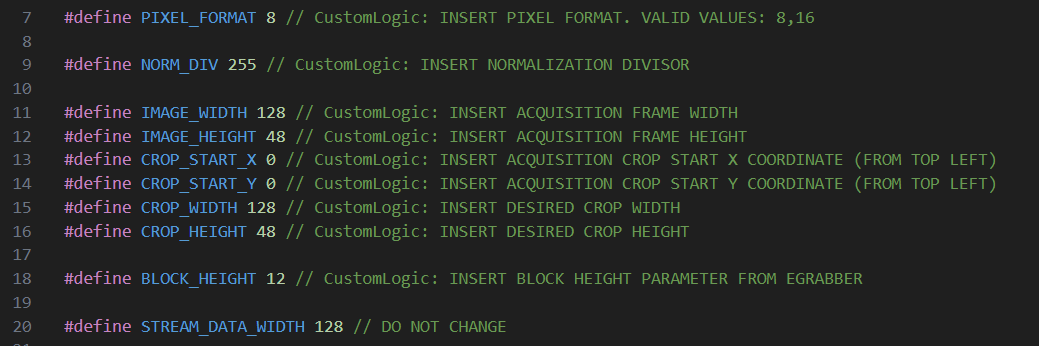

Now, at the bottom of ``CustomLogic.h`` we must enter the striping pattern which the frame grabber will receive out of the camera so the firmware can reoder the data before streaming into the model. Run the cell below to calculate the correct order. You will need to provide your image height and block height.

In [33]:
IMAGE_HEIGHT = 48
BLOCK_HEIGHT = 12

def gen_stripe_pattern(NUM_STRIPES):
    if NUM_STRIPES % 2 != 0:
        print("NUM_STRIPES must be even")
        return None
    
    stripe_order = []
    for i in range(NUM_STRIPES):
        if i % 2 == 0:
            stripe_order.append(((NUM_STRIPES // 2) - (i // 2)) - 1)
        else:
            stripe_order.append(((NUM_STRIPES // 2) + ((i + 1) // 2)) - 1)
    
    return stripe_order

NUM_STRIPES = IMAGE_HEIGHT/(BLOCK_HEIGHT/2)
stripe_order = str(gen_stripe_pattern(int(NUM_STRIPES))).replace('[', '{').replace(']', '}')
print("Copy this array to the strip_order constant in CustomLogic.h: ", stripe_order)

Copy this array to the strip_order constant in CustomLogic.h:  {3, 4, 2, 5, 1, 6, 0, 7}



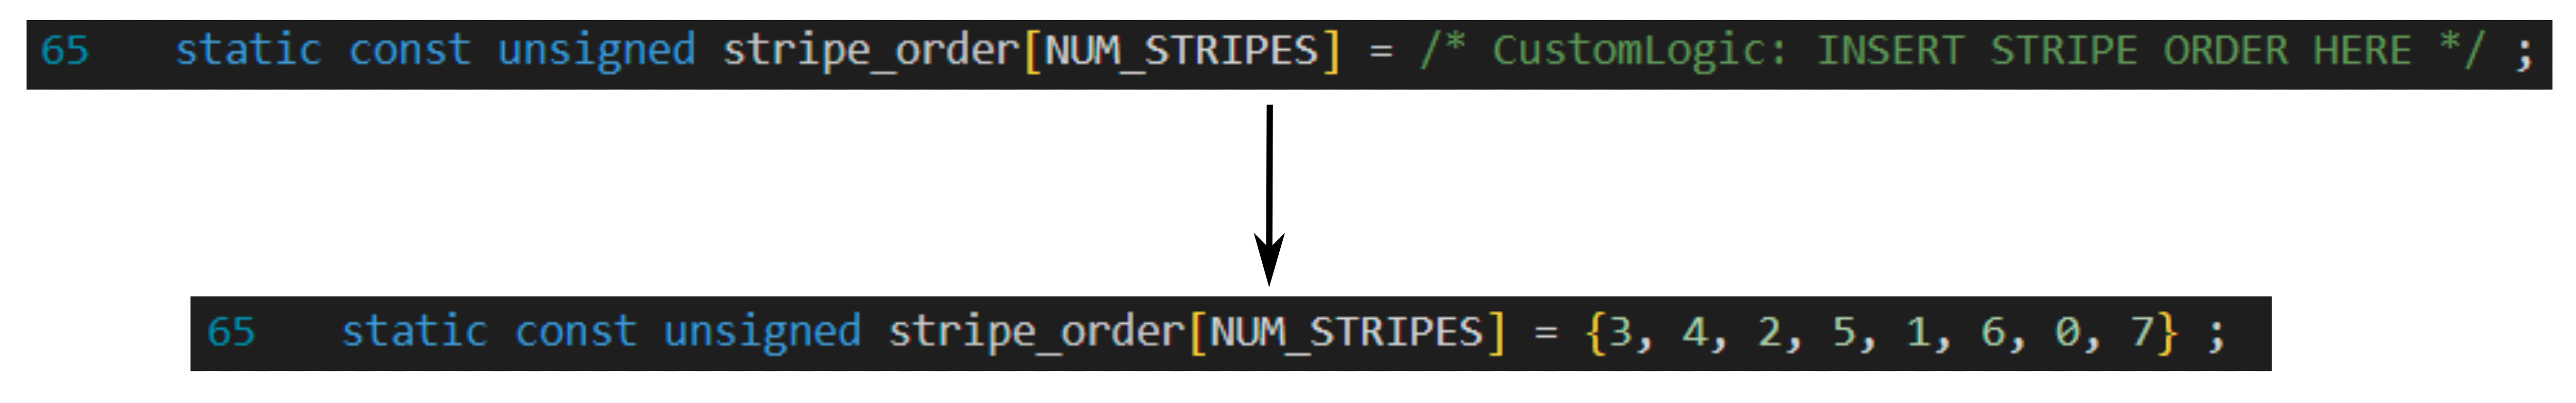

Now we'll begin copying over some HLS from your hls4ml project to the frame grabber template project.

First, set the value of ``MODEL_OUT_DEPTH`` to the depth of your model's output stream. For this FOLO model, we know the output stream will have a depth of 1×8×3=24 based on the shape of our ouput data.

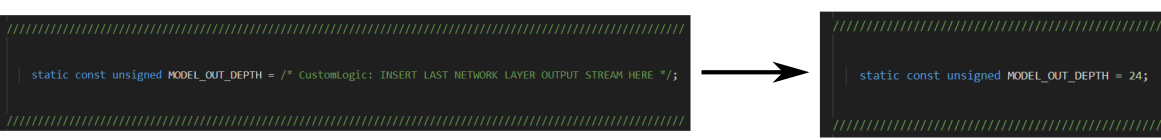

Next, we need to set the depths of the intermediate split input streams ``input_arr_split_reordered`` which reorder the frame input to natural order. Use the output of the cell below.


In [34]:
def generate_pragma_lines(NUM_STRIPES):
    for i in range(NUM_STRIPES):
        print(f'    #pragma HLS STREAM variable=input_arr_split_reordered[{i}] depth=PACKETS_PER_STRIPE')

generate_pragma_lines(int(NUM_STRIPES))  # This will generate 5 lines with incremented indices.


print("\n\nCopy the above HLS to myproject.cpp in the appropriate location")

    #pragma HLS STREAM variable=input_arr_split_reordered[0] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[1] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[2] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[3] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[4] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[5] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[6] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[7] depth=PACKETS_PER_STRIPE


Copy the above HLS to myproject.cpp in the appropriate location


Next, copy your weight import statements to ``myproject.cpp``to the position shown below.

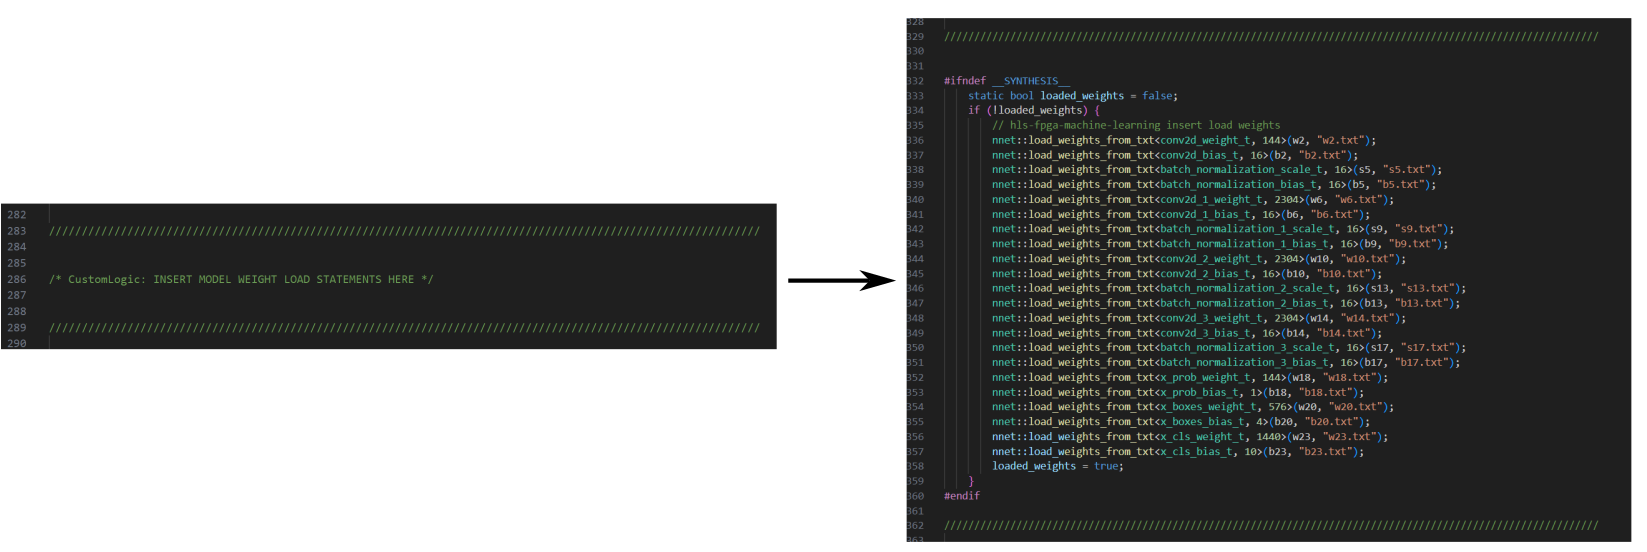

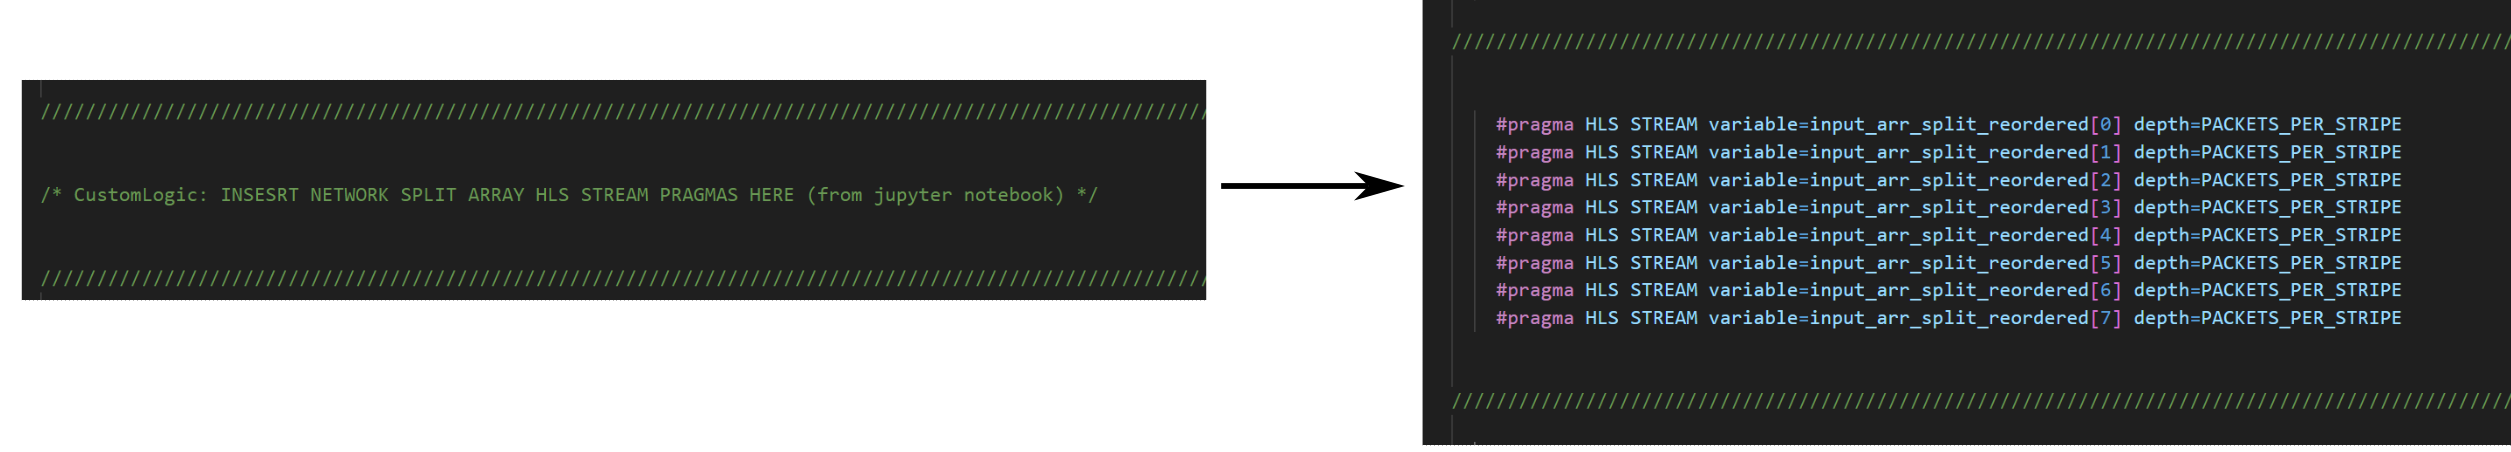

Next, let's copy over the model layers (truncated for viewing, yours may have ``save_layer_output()`` statements interleaved.

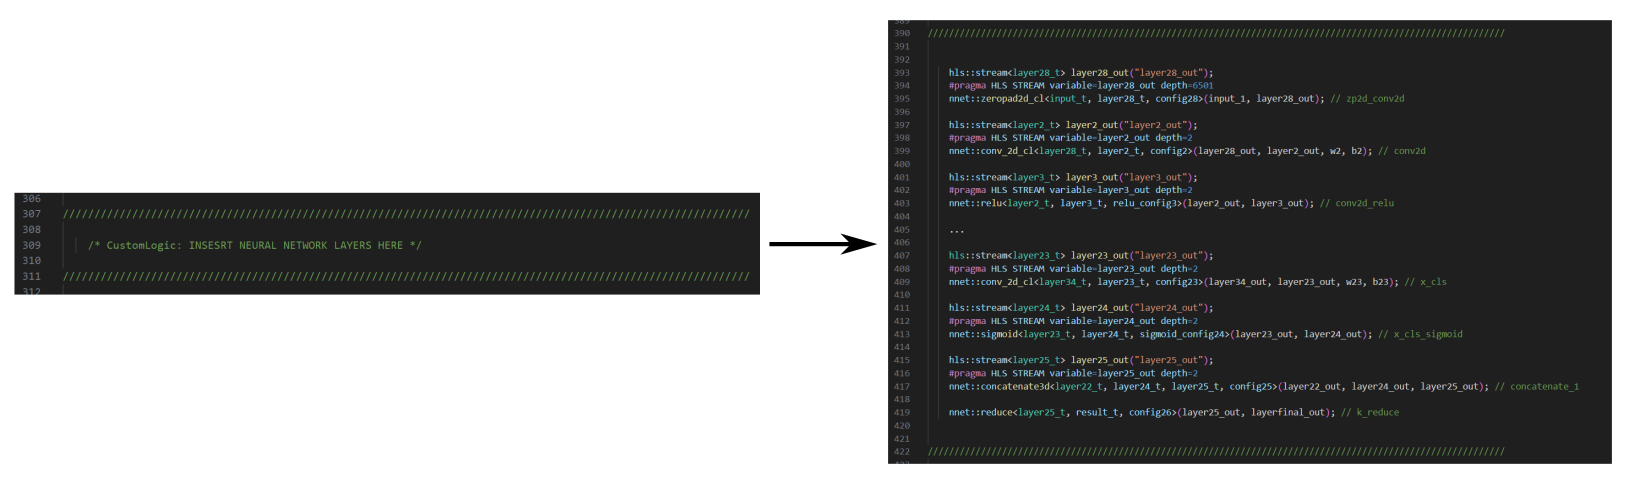

Lastly, we will need to change the name of the model output stream (``layer26_out`` in this case) to ``layerfinal_out``. Your model output stream should be the last stream argument of your networks final layer. ``attach_results()`` will then insert the neural network predictions at the beginning of the image.

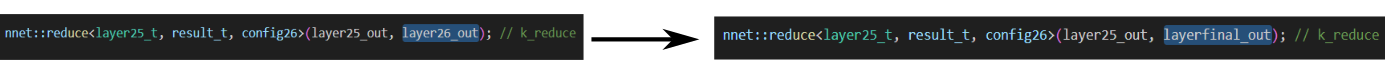

Now, in ``nnet_utils/nnet_helpers.h``, change ``WEIGHTS_DIR`` TO ``../../../../srcs/weights``

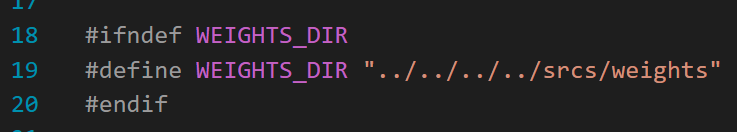

Now, in ``defines.h``, we have to add one include statement, ``#include "CustomLogic.h"``, at the top and one new type definition, ``typedef nnet::array<input_t::value_type, MONOPIX_NBR> input_arr_t;``

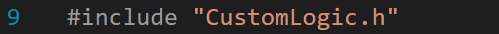

     
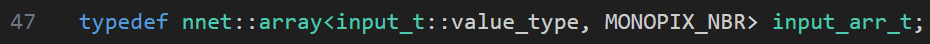
     

### C-simulation

Just like last time, lets save a small dataset to validate our frame grabber firmware with our Keras model via c-simulation.

In [35]:
FRAME_GRABBER_DIR = "my-frame-grabber-test_TEMPLATE/05_model_design_hls"
np.savetxt(FRAME_GRABBER_DIR + "/tb_data/tb_input_features.dat", X.reshape(X.shape[0], -1)*255.0, delimiter=' ', fmt='%d')
np.savetxt(FRAME_GRABBER_DIR + "/tb_data/tb_output_predictions.dat", np.zeros(y.shape[0:3]).reshape(y.shape[0], -1), delimiter=' ')

Now we can execute c-simulation to ensure our frame grabber firmware is producing the expected results

In [38]:
!vivado_hls {FRAME_GRABBER_DIR}/scripts/run_hls.tcl -f "csim=1 synth=0"


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /data1/rforelli/Xilinx_2018/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/data1/rforelli/Xilinx_2018/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rforelli' on host 'correlator2.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Fri Jun 21 14:18:17 CDT 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/home/rforelli/HFG_test/hls4ml-frame-grabbers'
EURESYS_INFO: [Initial path] /home/rforelli/HFG_test/hls4ml-frame-grabbers
EURESYS_INFO: [Script path] /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/scripts
EURESYS_INFO: [Source path] /home/rforelli

8132681 108812409 243307641 369548521 511780025 629370135 788891753 973203545 1066933609 93867337 269792630 1351024152 513216820 1686866423 1889398404 874504676 1060901449 96227945 238454297 414762425 498404889 674838948 817206761 926281337 
Processing input 14
12456 84173061 251566185 385800313 503387257 638010505 805281913 939382857 26103160 1091204616 245011785 370728313 513349977 1730256529 748523921 899406201 1060505078 137775574 247109209 372954713 515446329 657288753 775528049 918410857 
Processing input 15
8918146 109087060 167947641 394317897 528423017 645876825 797152361 948293718 1075078721 1150062097 1233565120 370986329 504961401 622416233 823646713 1889137289 1068635649 103831057 255101417 372953689 498799193 641419833 792038905 926407209 
Processing input 16
8132681 117332089 251566201 377410681 520031305 671440018 1862524323 889574615 1066934633 102259065 236493177 362338681 530260329 1696044657 1829490146 882630055 1060901449 104486489 238720601 372823641 515575353 657

8000537 142768342 193112384 377673893 528560341 662651929 805280889 931124313 1581385 1183882774 1233565144 1478175349 446111189 647972153 790208873 907793769 1069419065 112219652 246578615 405983705 515187280 650072665 784046697 909890137 
Processing input 46
1073485897 125718601 268996742 369152105 545077433 1677951381 1862393234 889321777 1067065705 119297369 220642937 362595657 538383621 630028693 806475222 873460128 1052380745 138040873 1294386841 364825193 498666041 666321353 783521287 909756953 
Processing input 47
1056967785 117849159 277000393 369418471 536811609 654135369 797154470 923132103 10112505 1092389588 252889538 1351417410 513605913 656105833 1880875602 1905650194 1060244985 103831049 246715929 406244839 507315764 674976281 800044633 901238313 
Processing input 48
1073483833 117461097 252091606 402709586 512170178 646278393 788636857 939381817 1066932553 110784983 194947623 388028809 496979569 1678743104 748002705 907792729 1052639785 120743495 1260959415 389603958 4

1073484857 100682841 252347513 385932425 511906963 671443145 771991799 931124297 1058672969 144341416 1209318024 404672841 1502692967 672241112 1753854450 899272009 1044251209 120868345 263359961 372690484 532219369 657675785 808814009 918409801 
Processing input 78
1065096281 126116017 276865129 394317894 495261908 654662837 780252421 930993209 1321305 1183885894 186286456 437847446 1494432358 1720821319 722843159 899403097 1069158969 129253814 247368265 398116326 506403353 674581957 783524441 910021209 
Processing input 79
1065358425 100947125 268082233 386196679 520302819 679433257 796892281 931124313 18364809 1091208772 261915913 1486304882 437591512 656231737 781950329 907793769 1052376553 129514953 264017481 397207049 515313172 649941609 784046681 909890137 
Processing input 80
25176169 1174445475 176337285 369539137 545334393 662656089 796892281 931124313 1718729 85487062 193640899 1469657761 479794561 647845225 773430649 907793769 3288665 1084391145 238449062 422761921 53209452

digit: 8, prob: 1, x1: 27, y1: 5, x2: 57, y2: 34
digit: 0, prob: 1, x1: 84, y1: 15, x2: 110, y2: 41
digit: 6, prob: 1, x1: 41, y1: 19, x2: 68, y2: 46


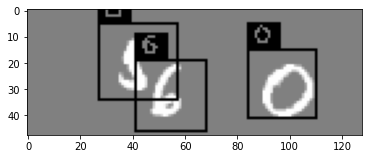

In [39]:
csim_predictions = np.genfromtxt(FRAME_GRABBER_DIR + "/tb_data/csim_results.log", delimiter=' ')
show_predict_hardware(X[0], csim_predictions[0])

### Frame grabber model classification performance

In [40]:
csim_y_pred = create_FOLO_output_from_hardware(csim_predictions)

In [41]:
csim_y_pred_ex, y_ex = eval_model_cls_performance(csim_y_pred, y)
FOLO_accuracy_csim = np.mean(csim_y_pred_ex == y_ex) * 100
print(f'FOLO csim classification accuracy: {FOLO_accuracy_csim:.2f}%')

FOLO csim classification accuracy: 78.20%


## C-synthesis

Now run c-synthesis to generate the RTL representation of our design

In [42]:
!vivado_hls {FRAME_GRABBER_DIR}/scripts/run_hls.tcl -f "csim=0 synth=1"


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /data1/rforelli/Xilinx_2018/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/data1/rforelli/Xilinx_2018/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rforelli' on host 'correlator2.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Fri Jun 21 14:23:58 CDT 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/home/rforelli/HFG_test/hls4ml-frame-grabbers'
EURESYS_INFO: [Initial path] /home/rforelli/HFG_test/hls4ml-frame-grabbers
EURESYS_INFO: [Script path] /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/scripts
EURESYS_INFO: [Source path] /home/rforelli

INFO: [HLS 200-489] Unrolling loop 'MultLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:136) in function 'void nnet::dense_resource_rf_gt_nin_rem0<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config20_mult>(FORWARD_REFERENCE*, FORWARD_REFERENCE*, FORWARD_REFERENCE::weight_t*, FORWARD_REFERENCE::bias_t*)' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:303) in function 'void nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config18>(FORWARD_REFERENCE const&, ap_shift_reg<FORWARD_REFERENCE::value_type, FORWARD_REFERENCE::in_width> (*) [FORWARD_REFERENCE::n_chan], hls::stream<

INFO: [XFORM 203-603] Inlining function 'nnet::dense_resource_rf_leq_nin<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253).
INFO: [XFORM 203-603] Inlining function 'nnet::cast<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:79->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_desig

INFO: [XFORM 203-603] Inlining function 'nnet::compute_pool_buffer_2d<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' into 'nnet::pooling2d_buffer_cl<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:247).
INFO: [XFORM 203-603] Inlining function 'nnet::pooling2d_buffer_cl<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_d

INFO: [XFORM 203-603] Inlining function 'nnet::product::mult<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0> >::product' into 'nnet::normalize<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_batchnorm_stream.h:42).
INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config29>' into 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config29>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:78).
INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<1

INFO: [XFORM 203-603] Inlining function 'nnet::conv_2d_buffer_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' into 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv2d_stream.h:103).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::compute_pool_buffer_2d<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:203).
INFO: [XFORM 203-603] Inlining function 'nne

INFO: [XFORM 203-603] Inlining function 'nnet::Op_max<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_common.h:43->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_common.h:45->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:21->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:204->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:247->/home/rforelli/HFG_test/hls4ml-f

INFO: [XFORM 203-603] Inlining function 'nnet::pooling2d_buffer_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:257).
INFO: [XFORM 203-603] Inlining function 'nnet::shift_line_buffer<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:188->/home/rforelli/HFG_tes

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::normalize<nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config17>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_batchnorm_stream.h:42).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::relu<nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, relu_config15>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:54).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::relu<nne

INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config34>' into 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config34>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:78).
INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config34>' into 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config34>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:70).
INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>::operator[]' into 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config20>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:305).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>::operator[]' into 'nnet::concatenate3d_2<nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, config22>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_merge_stream.h:251).
INFO: [XFORM 203-603] Inlining function 'nnet::conv_2d_buffer_cl<nnet::

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_uint<31>, 1u>::operator[]' into 'nnet::reduce<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 15u>, nnet::array<ap_uint<31>, 1u>, config26>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_reduce.h:38).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_uint<31>, 1u>::operator[]' into 'nnet::reduce<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 15u>, nnet::array<ap_uint<31>, 1u>, config26>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_reduce.h:37).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_uint<31>, 1u>::operator[]' into 'nnet::reduce<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 15u>, nnet::array<ap_uint<31>, 1u>, config26>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet

INFO: [XFORM 203-1101] Packing variable 'res_pack.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:282) into a 256-bit variable.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'InputSplitLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:44) in function 'unpack_data' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'FrameLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:110) in function 'read_pixel_data' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'SigmoidActLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:80) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>

INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'BatchNormLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_batchnorm_stream.h:25) in function 'nnet::normalize<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ConcatLoopWidth' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_merge_stream.h:234) in function 'nnet::concatenate3d_2<nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, config22>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ConcatLoopWidth' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/

INFO: [HLS 200-489] Unrolling loop 'Loop-1.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config31>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config31>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.2.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:22) in function 'nnet::zeropad

INFO: [HLS 200-489] Unrolling loop 'Loop-2.3' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config33>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-3.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config33>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-1.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d

INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:194) in functio

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'FiltLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:193) in function '

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:303) in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 7, (a

INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a facto

INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor o

INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.4' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.3' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.2' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.10' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.1' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V' .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'input_arr_split_reordered.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:365) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'input_1.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:

INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.9' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.14' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.19' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.24' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.29' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.34' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.10' in dimension 1 completely.

INFO: [XFORM 203-101] Partitioning array 'res_out'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b10.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:33) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:229) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'kernel_data.V.4'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res_out'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b6.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/

INFO: [XFORM 203-101] Partitioning array 'layer12_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:448) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer16_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:468) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer4_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:408) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer17_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:472) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer20_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_mode

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 37 process function(s): 
	 'read_pixel_data'
	 'unpack_data'
	 'nnet::zeropad2d_cl<nnet::array<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config28>'
	 'nnet::conv_2d_cl<nnet::array<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, relu_config3>'
	 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>'
	 'nnet::normalize<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config5>'
	 'nnet::zeropad2d_cl<nnet::array<ap_f

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_reduce.h:25:37) to (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_reduce.h:25:31) in function 'nnet::reduce<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 15u>, nnet::array<ap_uint<31>, 1u>, config26>'... converting 29 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:248:2) to (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:246:129) in function 'attach_results'... converting 4 basic blocks.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (

INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv2d_stream.h:79:66) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config2>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv2d_stream.h:79:66) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv2d_stream.h:79:66) in function 'nnet::conv_2d_cl<nnet::ar

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource.6'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource.5'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource.4'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource.3'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-t

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'read_pixel_data' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	75	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints

INFO: [HLS 200-111]  Elapsed time: 1.69 seconds; current allocated memory: 1.224 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.86 seconds; current allocated memory: 1.227 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	31	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'add' operation ('tmp47', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_478', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' operation ('tmp_476', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mul

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'add' operation ('tmp35', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_450', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' operation ('tmp_448', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mul

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'add' operation ('tmp20', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_412', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' operation ('tmp_410', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mul

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'add' operation ('tmp5', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_374', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' operation ('tmp_373', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult

INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.85 seconds; current allocated memory: 1.235 GB.
INFO: [BIND 205-100] Starting micro-architect

INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
	'load' operation ('sX_9_load', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:191->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:247->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:257) on static variable 'sX_9' [209]  (0 ns)
	'add' operation ('phitmp_i_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-gr

INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.21 seconds; current allocated memory: 1.242 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 4.95 seconds; current allocated memory: 1.291 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_3' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	47	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence const

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_415', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_57_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_56 = tmp_487_56 * r_V_57
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_412', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_379', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_46_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_45 = tmp_487_45 * r_V_46
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_376', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_334', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_32_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_31 = tmp_487_31 * r_V_32
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_330', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_288', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_18_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_17 = tmp_487_17 * r_V_18
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_285', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_247', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_4_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_4 = tmp_487_4 * r_V_4
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_244', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'partselect' operation ('tmp_391', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_394', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' opera

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'add' operation ('tmp38', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_336', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'phi' operation ('acc[8].V') with incoming values : ('acc[8].V', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_desig

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'partselect' operation ('tmp_300', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_303', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' opera

###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 64	0	0	724	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 9.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INF

INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc gr

INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished 

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_856_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_20_10_i = tmp_515_10_i * r_V_i
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_852_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/h

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'load' operation ('w10_V_load', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253) on array 'w10_V'
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_20_i = tmp_515_i * r_V_i
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 32	0	0	237	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [S

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 16	0	16	73	32	2	2	2	2	16	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [S

###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	57	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'BatchNormLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 7.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
I

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_801_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255)
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255)
  DSP48 Expression: r_V_18_1_i = tmp_502_1_i * r_V_i
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_804_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/

INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
	'call' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:297)

INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
	'load' operation ('sX_8_load', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grab

INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.28 seconds; current allocated memory: 1.378 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.34 seconds; current allocated memory: 1.382 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_6' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	289	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SC

INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.28 seconds; current allocated memory: 1.387 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.12 seconds; current allocated memory: 1.388 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_5' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	25	0	-nan	0	-nan	0	0	0
I

INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.78 seconds; current allocated memory: 1.392 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_4' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'load' operation ('w20_V_load', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255) on array 'w20_V'
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nne

INFO: [HLS 200-111]  Elapsed time: 1.4 seconds; current allocated memory: 1.395 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.17 seconds; current allocated memory: 1.396 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_4' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	25	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints 

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_5' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'load' operation ('w23_V_load', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255) on array 'w23_V'
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255)
  DSP48 Express

INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.56 seconds; current allocated memory: 1.403 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.22 seconds; current allocated memory: 1.405 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_6' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	25	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'concatenate3d_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	2	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints 

INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'CloneLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints .

INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl'.
INFO: [HLS 200-111]  Elapsed time: 1.04 seconds; current allocated memory: 1.490 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu'.
INFO: [HLS 200-111]  Elapsed time: 0.85 seconds; current allocated memory: 1.492 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'pooling2d_cl_3' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_1'.
INFO: [HLS 200-111]  Elapsed time: 9.38 seconds; current allocated memory: 1.700 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_1'.
INFO: [HLS 200-111]  Elapsed time: 2.19 seconds; current allocated memory: 1.709 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_1'.
INFO: [HLS 200-111]  Elapsed time: 1.25 seconds; current allocated memory: 1.711 GB.
INFO: [HLS 200-10] ------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_32_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl'.
INFO: [HLS 200-111]  Elapsed time: 2.05 seconds; current allocated memory: 1.717 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_13ns_29_3_1': 4 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_14ns_29_3_1': 12 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize'.
INFO: [HLS 200-111]  Elapsed time: 2.7 seconds; current allocated memory: 1.727 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_2' 
INFO: [HLS 200-10] -------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_3'.
INFO: [HLS 200-111]  Elapsed time: 6.56 seconds; current allocated memory: 1.819 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_3' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_3'.
INFO: [HLS 200-111]  Elapsed time: 1.97 seconds; current allocated memory: 1.828 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_2'.
INFO: [HLS 200-111]  Elapsed time: 0.92 seconds; current allocated memory: 1.830 GB.
INFO: [HLS 200-10] ------------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_2'.
INFO: [HLS 200-111]  Elapsed time: 6.55 seconds; current allocated memory: 1.936 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_2'.
INFO: [HLS 200-111]  Elapsed time: 2.04 seconds; current allocated memory: 1.945 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_3' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_3'.
INFO: [HLS 200-111]  Elapsed time: 1.01 seconds; current allocated memory: 1.948 GB.
INFO: [HLS 200-10] ------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_12ns_28_3_1': 6 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_13ns_28_3_1': 8 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_14ns_28_3_1': 2 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_2'.
INFO: [HLS 200-111]  Elapsed time: 2.92 seconds; current allocated memory: 1.964 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'clone_stream_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'clone_stream_1'.
INFO: [HLS 200-111]  Elapsed time: 1.48 seconds; current allocated memory: 1.967 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_4' 
INFO: [HLS 

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_5'.
INFO: [HLS 200-111]  Elapsed time: 6.41 seconds; current allocated memory: 2.057 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_5' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_5'.
INFO: [HLS 200-111]  Elapsed time: 2.02 seconds; current allocated memory: 2.065 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid'.
INFO: [HLS 200-111]  Elapsed time: 1.01 seconds; current allocated memory: 2.067 GB.
INFO: [HLS 200-10] ----------------------------------------------------

INFO: [HLS 200-111]  Elapsed time: 1.83 seconds; current allocated memory: 2.113 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_4' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_mul_16s_18s_34_4_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_1448_16_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_4'.
INFO: [HLS 200-111]  Elapsed time: 1.81 seconds; current allocated memory: 2.119 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffe_4' 
INFO: [HLS 200-10] -----------------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_4'.
INFO: [HLS 200-111]  Elapsed time: 6.75 seconds; current allocated memory: 2.150 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_4' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_4'.
INFO: [HLS 200-111]  Elapsed time: 2.09 seconds; current allocated memory: 2.158 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'concatenate3d' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'concatenate3d'.
INFO: [HLS 200-111]  Elapsed time: 1.06 seconds; current allocated memory: 2.159 GB.
INFO: [HLS 200-10] ----------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_6'.
INFO: [HLS 200-111]  Elapsed time: 7.09 seconds; current allocated memory: 2.244 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_6' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_6'.
INFO: [HLS 200-111]  Elapsed time: 2.13 seconds; current allocated memory: 2.253 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_1'.
INFO: [HLS 200-111]  Elapsed time: 1.15 seconds; current allocated memory: 2.256 GB.
INFO: [HLS 200-10] ------------------------------------------------

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_DsizeL_V' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_PixelF' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_TapG' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_Flags' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_Timestamp' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_PixProcessingFlgs' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_ModPixelF' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_Status' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaOut_StreamId' to 'ap_none'.
INFO: [RTGEN 206-500] Settin

INFO: [RTMG 210-279] Implementing memory 'dense_resource_5_outidx_rom' using auto ROMs.
INFO: [RTMG 210-279] Implementing memory 'dense_resource_5_w23_V_rom' using auto ROMs.
INFO: [RTMG 210-279] Implementing memory 'sigmoid_1_sigmoid_table3_rom' using block ROMs.
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_axi_urem_32ns_6ns_5_36_1_div'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_axi_urem_32ns_6ns_32_36_1_div'
INFO: [RTMG 210-285] Implementing FIFO 'VideoBuffer_V_Data_V_U(fifo_w128_d384_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'VideoBuffer_V_User_V_U(fifo_w4_d384_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_283_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_284_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_285_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_sp

INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_358_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_359_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_360_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_361_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_362_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_363_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_364_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_365_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_366_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_367_U(fifo_w32_d48_A)

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_10_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_11_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_12_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_13_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_14_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_15_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_0_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_V_data_3_U(fifo_w16_d2_A)' using S

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_12_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_13_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_14_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_15_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_0_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_5_U(fifo_w16_d2_A)' using Shi

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_1_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_1_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_1_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_0_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer12_out_V_data_6_U(fifo_w16_d2_A

INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_1_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_1_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_1_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_0_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer16_out_V_data_6_U(fifo_w16_d2_A

INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_13_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_14_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_15_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_0_U(fifo_w16_d27_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_1_U(fifo_w16_d27_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_2_U(fifo_w16_d27_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_3_U(fifo_w16_d27_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_4_U(fifo_w16_d27_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_5_U(fifo_w16_d27_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer34_out_V_data_6_U(fifo_w1

INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_8_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_9_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_0_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_7_U(fifo_w16_d2_A)' usi

## Implementation

Run logic synthesis and place & route. This runtime can go long so we recommend executing the following in a command line rather in through this notebok. We use ``nohup`` for no hang up and ``&`` to put it in the background.

```bash
nohup vivado -mode tcl -source 03_scripts/run_impl.tcl &
```

## Benchmarking

RTL is written to mark the start and completion of your model inference. You may connect an oscilloscope to TTLIO11 and record the high-time to determine your model's latency.